In [1]:
# Data manipulation and analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array manipulation
import scipy as sp  # For scientific and technical computing
from scipy.special import expit  # For the sigmoid function, the choice function
from scipy import stats  # To draw from a truncated normal disterbution

# Probabilistic programming and Bayesian statistical modeling
import pymc as pm  
import arviz as az  

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns  

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger("pymc")
logger.propagate = False
logger.setLevel(logging.ERROR)

In [2]:
# Loading the CSV file into a pandas DataFrame
# 'sim.csv' is the file that contains the dataset with all the different possible choices
db = pd.read_csv('Simulated_Choices.csv')

In [3]:
def simulate_choices_with_distribution(trials_df, n_subs, 
                                       mean_a=1.5, sd_a=0.5, 
                                       mean_b=2.0, sd_b=0.5, 
                                       mean_c=2.5, sd_c=0.5,
                                       min_ratio=1/20, max_ratio=20,
                                       noise = .1):
    """
    Simulate choices for each subject using a logistic choice function, with values drawn from a normal distribution
    for each comparison based on group means and SDs for A, B, and C.

    Parameters:
    - trials_df: DataFrame containing trial configurations (LeftN, LeftV, LeftP, RightN, RightV, RightP).
    - n_subs: Number of subjects.
    - mean_a, mean_b, mean_c: Group means for stimuli A, B, and C.
    - sd_a, sd_b, sd_c: Group standard deviations for stimuli A, B, and C.

    Returns:
    - choices_df: DataFrame with all trial results for each participant using a logistic choice function.
    - values_df: DataFrame with individual subject means for each stimulus (A, B, C).
    """
    
    # Store the choice data and individual values for each subject
    choice_data = []
    values_data = []
    
    # Loop over each subject
    for subject in range(n_subs):

        while True:
            value_a = np.abs(np.random.normal(mean_a, sd_a))
            value_b = np.abs(np.random.normal(mean_b, sd_b))
            value_c = np.abs(np.random.normal(mean_c, sd_c))
            
            # Calculate ratios
            ab_ratio = value_a / value_b
            ac_ratio = value_a / value_c
            bc_ratio = value_b / value_c
            
            # Check if all ratios are within the desired range
            if (min_ratio <= ab_ratio <= max_ratio and
                min_ratio <= ac_ratio <= max_ratio and
                min_ratio <= bc_ratio <= max_ratio):
                break  # Exit the loop if ratios are valid
                
        # Draw mean values for each subject from group-level distributions for A, B, and C
        subject_mean_a = value_a
        subject_mean_b = value_b
        subject_mean_c = value_c

        # Append subject-specific means to values data
        values_data.append({
            'Subject': subject,
            'Subject_Mean_A': subject_mean_a,
            'Subject_Mean_B': subject_mean_b,
            'Subject_Mean_C': subject_mean_c
        })

        # Simulate choices for each trial for this subject
        for _, trial in trials_df.iterrows():
            LeftN, LeftV, LeftP, RightN, RightV, RightP = trial
            
            # Draw values for each comparison from subject-specific normal distributions
            left_value = np.random.normal(subject_mean_a, noise) if LeftV == 'A' else \
                         np.random.normal(subject_mean_b, noise) if LeftV == 'B' else \
                         np.random.normal(subject_mean_c, noise)

            right_value = np.random.normal(subject_mean_a, noise) if RightV == 'A' else \
                          np.random.normal(subject_mean_b, noise) if RightV == 'B' else \
                          np.random.normal(subject_mean_c, noise)
            
            # Calculate the subjective value for left and right options
            sv_left = LeftN * LeftP * left_value
            sv_right = RightN * RightP * right_value
            
            # Apply logistic function for choice probability
            p = expit(sv_left - sv_right)  # Probability of choosing left option
            choice = np.random.binomial(1, p)  # Choice: 1 for left, 0 for right
            
            # Append choice data
            choice_data.append([subject, LeftN, LeftV, LeftP, RightN, RightV, RightP, choice])

    # Create DataFrames
    choices_df = pd.DataFrame(choice_data, columns=['Subject', 'LeftN', 'LeftV', 'LeftP', 
                                                    'RightN', 'RightV', 'RightP', 'Choice'])
    values_df = pd.DataFrame(values_data)

    return choices_df, values_df

In [4]:
choices_df, values_df = simulate_choices_with_distribution(db, n_subs=100, noise=.3)

In [5]:
def estimate_value(df, n_subs, idx, draw_model=False):
    """
    Estimate the subjective values for each subject based on simulated choice data using a logistic function with subject-specific inverse temperature.
    Optionally, only draws the model structure.

    Parameters:
    - df: DataFrame containing simulated trials and choices.
    - n_subs: Number of subjects.
    - idx: Array of subject indices for each trial.
    - draw_model: If True, outputs a visualization of the model structure instead of sampling.

    Returns:
    - trace: PyMC trace object containing posterior samples, or the model structure if draw_model=True.
    """

    # Convert 'LeftV' and 'RightV' to numerical indices (A = 0, B = 1, C = 2)
    value_map = {'A': 0, 'B': 1, 'C': 2}
    left_values = df['LeftV'].map(value_map).values
    right_values = df['RightV'].map(value_map).values

    with pm.Model() as estimate:

        # Subject-specific priors for values
        A_value = pm.Normal('A_value', 2, 1, shape=n_subs)
        B_value = pm.Normal('B_value', 2, 1, shape=n_subs)
        C_value = pm.Normal('C_value', 2, 1, shape=n_subs)

        # Combine A, B, C values into a tensor for easier indexing
        values = pm.math.stack([A_value, B_value, C_value], axis=0)

        # Define the subject-specific risk preference (γ) using a lognormal distribution
        gamma = pm.Lognormal('gamma', 0, .25, shape=n_subs)

        # Extract subjective values for each trial's left and right options
        left_V = values[left_values, idx]
        right_V = values[right_values, idx]

        # Compute the subjective value for each option
        svLeft = left_V * df['LeftN'].values * df['LeftP'].values
        svRight = right_V * df['RightN'].values * df['RightP'].values

        # Calculate choice probability using a logistic function with gamma
        p = (svLeft - svRight) / gamma[idx]
        mu = pm.invlogit(p)

        # Likelihood of observed choices
        choice = pm.Binomial('choice', n=1, p=mu, observed=df['Choice'].values)

        if draw_model:
            # Return model structure if draw_model is True
            return estimate.to_graphviz()
        else:
            # Sample from the posterior
            trace = pm.sample(idata_kwargs={'log_likelihood': True})
            return trace

In [6]:
# Count the number of unique subjects in the 'db_mon' dataset.
n_subs = choices_df['Subject'].unique().shape[0]

# Create a list of subject indices for all rows in the 'db_mon' dataset.
sub_idx = choices_df.Subject.tolist()


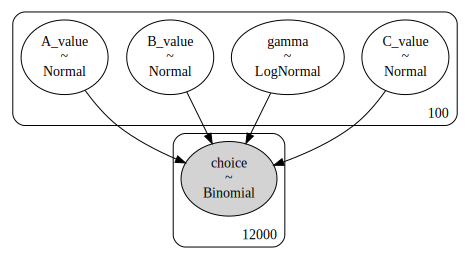

In [7]:
estimate_value(choices_df, n_subs, sub_idx, draw_model=True)

In [8]:
trace = estimate_value(choices_df, n_subs, sub_idx)

Output()

In [9]:
est_a = trace.posterior['A_value'].mean(dim=["chain", "draw"]).values
est_b = trace.posterior['B_value'].mean(dim=["chain", "draw"]).values
est_c = trace.posterior['C_value'].mean(dim=["chain", "draw"]).values

values_df['Estimated_A'] = est_a
values_df['Estimated_B'] = est_b
values_df['Estimated_C'] = est_c

# Calculate real and estimated ratios
values_df['Real_A_B_Ratio'] = values_df['Subject_Mean_A'] / values_df['Subject_Mean_B']
values_df['Real_A_C_Ratio'] = values_df['Subject_Mean_A'] / values_df['Subject_Mean_C']
values_df['Real_B_C_Ratio'] = values_df['Subject_Mean_B'] / values_df['Subject_Mean_C']

values_df['Estimated_A_B_Ratio'] = values_df['Estimated_A'] / values_df['Estimated_B']
values_df['Estimated_A_C_Ratio'] = values_df['Estimated_A'] / values_df['Estimated_C']
values_df['Estimated_B_C_Ratio'] = values_df['Estimated_B'] / values_df['Estimated_C']

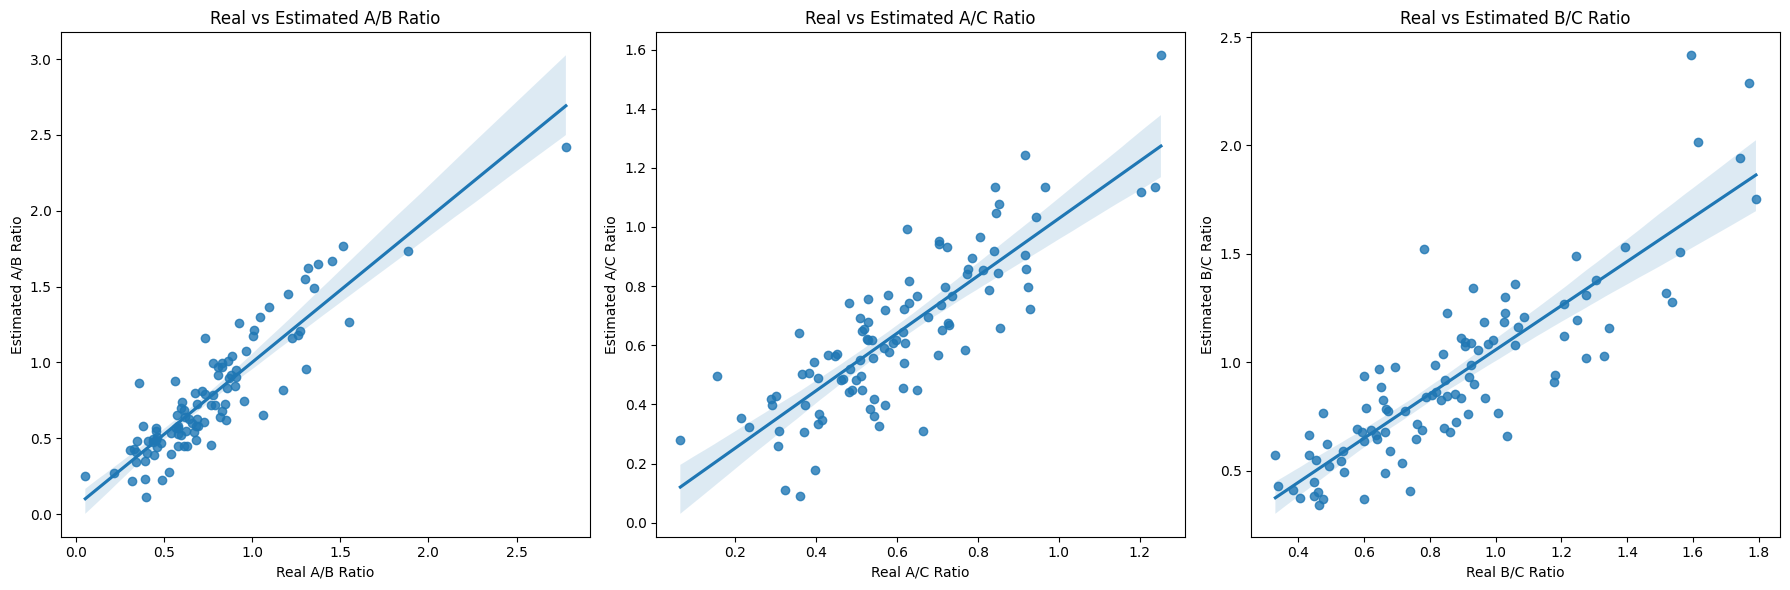

In [10]:
# Set up the plot with 3 panes for each ratio
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Real A/B Ratio vs Estimated A/B Ratio
sns.regplot(data=values_df, x='Real_A_B_Ratio', y='Estimated_A_B_Ratio', ax=axes[0])
axes[0].set_title('Real vs Estimated A/B Ratio')
axes[0].set_xlabel('Real A/B Ratio')
axes[0].set_ylabel('Estimated A/B Ratio')

# Plot Real A/C Ratio vs Estimated A/C Ratio
sns.regplot(data=values_df, x='Real_A_C_Ratio', y='Estimated_A_C_Ratio', ax=axes[1])
axes[1].set_title('Real vs Estimated A/C Ratio')
axes[1].set_xlabel('Real A/C Ratio')
axes[1].set_ylabel('Estimated A/C Ratio')

# Plot Real B/C Ratio vs Estimated B/C Ratio
sns.regplot(data=values_df, x='Real_B_C_Ratio', y='Estimated_B_C_Ratio', ax=axes[2])
axes[2].set_title('Real vs Estimated B/C Ratio')
axes[2].set_xlabel('Real B/C Ratio')
axes[2].set_ylabel('Estimated B/C Ratio')

plt.tight_layout()
plt.show()

In [11]:
# Filter out B vs C comparisons
filtered_choices_df = choices_df[~((choices_df['LeftV'] == 'B') & (choices_df['RightV'] == 'C')) & 
                                 ~((choices_df['LeftV'] == 'C') & (choices_df['RightV'] == 'B'))]

sub_idx_f = filtered_choices_df.Subject.tolist()


In [12]:
trace_bc = estimate_value(filtered_choices_df, n_subs, sub_idx_f)

Output()

In [13]:
est_a = trace_bc.posterior['A_value'].mean(dim=["chain", "draw"]).values
est_b = trace_bc.posterior['B_value'].mean(dim=["chain", "draw"]).values
est_c = trace_bc.posterior['C_value'].mean(dim=["chain", "draw"]).values

values_df['Estimated_A'] = est_a
values_df['Estimated_B'] = est_b
values_df['Estimated_C'] = est_c

values_df['Estimated_A_B_Ratio'] = values_df['Estimated_A'] / values_df['Estimated_B']
values_df['Estimated_A_C_Ratio'] = values_df['Estimated_A'] / values_df['Estimated_C']
values_df['Estimated_B_C_Ratio'] = values_df['Estimated_B'] / values_df['Estimated_C']

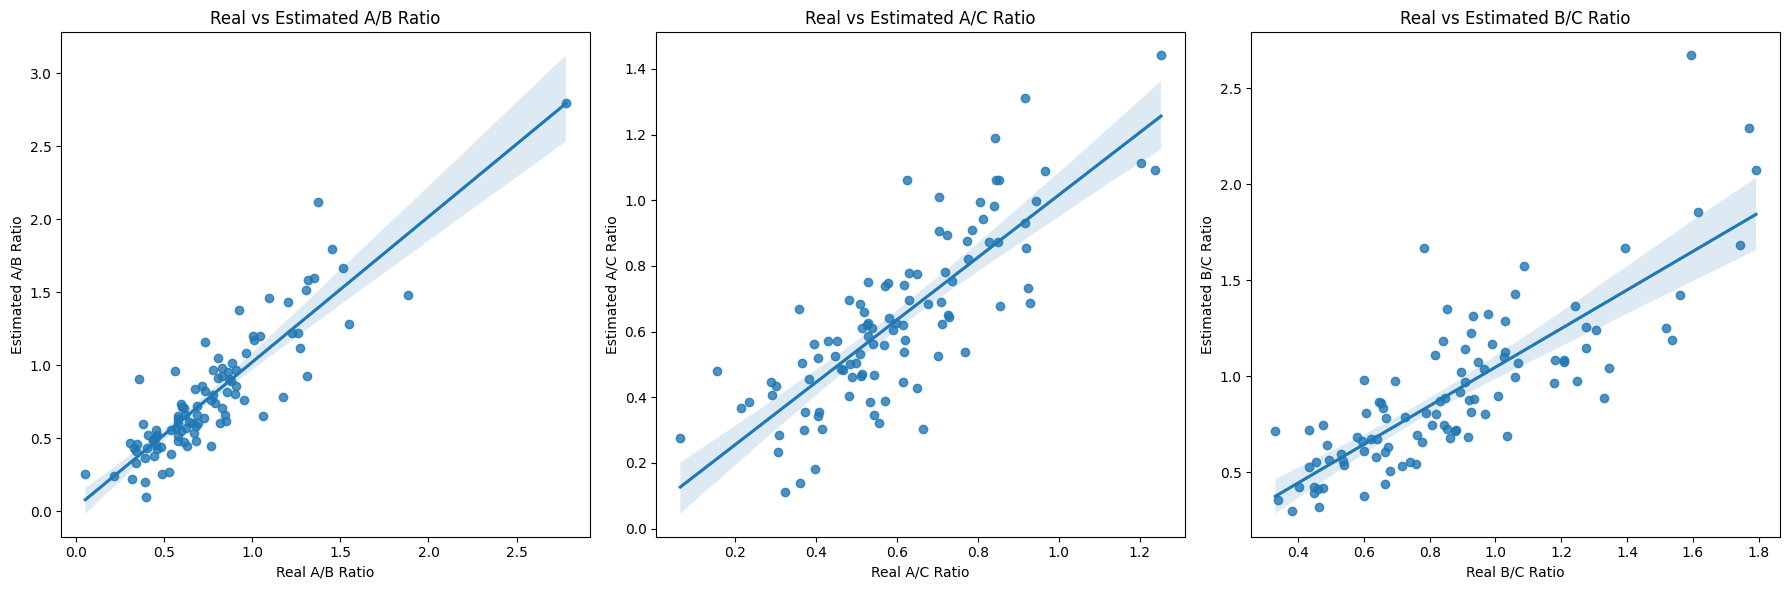

In [14]:
# Set up the plot with 3 panes for each ratio
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Real A/B Ratio vs Estimated A/B Ratio
sns.regplot(data=values_df, x='Real_A_B_Ratio', y='Estimated_A_B_Ratio', ax=axes[0])
axes[0].set_title('Real vs Estimated A/B Ratio')
axes[0].set_xlabel('Real A/B Ratio')
axes[0].set_ylabel('Estimated A/B Ratio')

# Plot Real A/C Ratio vs Estimated A/C Ratio
sns.regplot(data=values_df, x='Real_A_C_Ratio', y='Estimated_A_C_Ratio', ax=axes[1])
axes[1].set_title('Real vs Estimated A/C Ratio')
axes[1].set_xlabel('Real A/C Ratio')
axes[1].set_ylabel('Estimated A/C Ratio')

# Plot Real B/C Ratio vs Estimated B/C Ratio
sns.regplot(data=values_df, x='Real_B_C_Ratio', y='Estimated_B_C_Ratio', ax=axes[2])
axes[2].set_title('Real vs Estimated B/C Ratio')
axes[2].set_xlabel('Real B/C Ratio')
axes[2].set_ylabel('Estimated B/C Ratio')

plt.tight_layout()
plt.show()

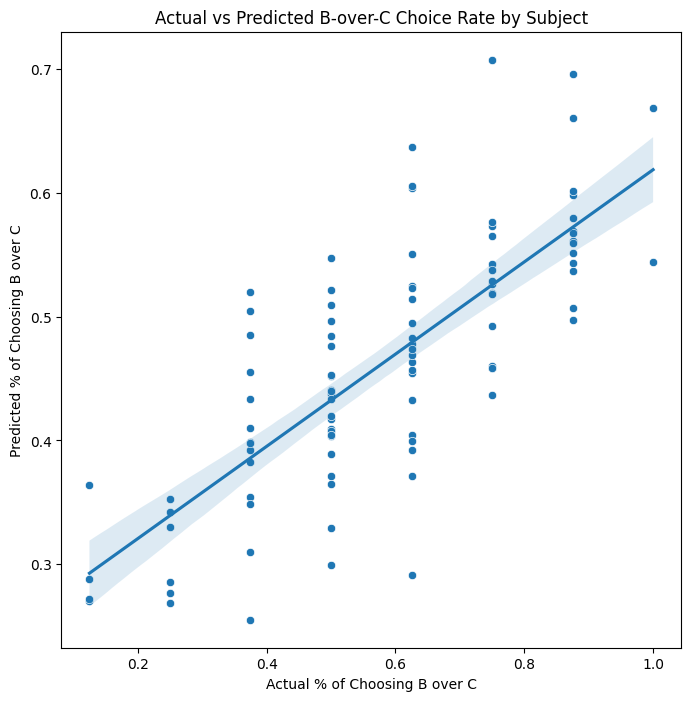

In [15]:

# Extract posterior means of estimated values for B and C
est_b = trace.posterior['B_value'].mean(dim=["chain", "draw"]).values
est_c = trace.posterior['C_value'].mean(dim=["chain", "draw"]).values

# Calculate predicted B-over-C choice probability based on estimated values
predicted_choice_rate = est_b / (est_b + est_c)

# Calculate actual percentage of time each subject chose B over C in `choices_df`
actual_choice_rate = []
for subject in range(n_subs):
    # Filter choices for subject's trials where options are B and C
    subject_choices = choices_df[(choices_df['Subject'] == subject) & 
                                 ((choices_df['LeftV'] == 'B') & (choices_df['RightV'] == 'C') |
                                  (choices_df['LeftV'] == 'C') & (choices_df['RightV'] == 'B'))]
    
    # Count choices where B was chosen (1 when B was chosen over C)
    b_choices = subject_choices[
        ((subject_choices['LeftV'] == 'B') & (subject_choices['Choice'] == 1)) |
        ((subject_choices['RightV'] == 'B') & (subject_choices['Choice'] == 0))
    ].shape[0]
    
    # Calculate actual B-over-C choice rate as a percentage
    total_choices = subject_choices.shape[0]
    choice_rate = (b_choices / total_choices) if total_choices > 0 else np.nan
    actual_choice_rate.append(choice_rate)

# Prepare DataFrame for plotting
plot_df = pd.DataFrame({
    'Subject': range(n_subs),
    'Actual_B_over_C_Rate': actual_choice_rate,
    'Predicted_B_over_C_Rate': predicted_choice_rate
})

# Scatter plot: actual vs predicted B-over-C choice rate
plt.figure(figsize=(8, 8))
sns.scatterplot(data=plot_df, x='Actual_B_over_C_Rate', y='Predicted_B_over_C_Rate')
sns.regplot(data=plot_df, x='Actual_B_over_C_Rate', y='Predicted_B_over_C_Rate', scatter=False)
plt.xlabel('Actual % of Choosing B over C')
plt.ylabel('Predicted % of Choosing B over C')
plt.title('Actual vs Predicted B-over-C Choice Rate by Subject')
plt.show()